This process is learnt from here: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

Import packages need

In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## 1. Load data
The data set is pre-cleaned leaving only respondents with narrative. In this process, I keep only the 'Consumer.complaint.narrative' and 'Sub.issue'

In [3]:
complaints_df = pd.read_csv('OneDrive/consumer_narrative.csv',nrows=50000)

In [5]:
df = complaints_df[['Consumer.complaint.narrative','Sub.issue']]

remove na

In [6]:
df.dropna(axis=0,inplace=True) #dropping na

## 2. Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove XXXX

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [8]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'x{2,}', '', newString) #remove 'xxx','xx','xxxxx'....
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
cleaned_narrative = []
for t in df['Consumer.complaint.narrative']:
    cleaned_narrative.append(text_cleaner(t,0))

In [10]:
cleaned_narrative[:5]

['transworld systems inc trying collect debt mine owed inaccurate',
 'would like request suppression following items credit report result falling victim identity theft information relate transactions made accounts opened attached supporting documentation attest blocked appearing credit report pursuant section fair credit reporting act',
 'past weeks receiving excessive amounts telephone calls company listed complaint calls occur cell job company right harass work want stop extremely distracting told times day call collection agency work',
 'checking credit report noticed three collections company called ars unfamiliar disputed collections replied contacted creditor creditor verified debt asked proof bureaus replied required prove anything mailed certified letter ars requesting proof debts form original aggrement proof right debt even much process bill calculated simply replied letter collection claim listed name account number amount information verify debts sent clear notice provide e

In [11]:
cleaned_issue = []
for t in df['Sub.issue']:
    cleaned_issue.append(text_cleaner(t,1))

In [12]:
cleaned_issue[:10]

['debt is not yours',
 'information belongs to someone else',
 'frequent or repeated calls',
 'debt is not yours',
 'account information incorrect',
 'personal information incorrect',
 'personal information incorrect',
 'their investigation did not fix an error on your report',
 'their investigation did not fix an error on your report',
 'credit inquiries on your report that you do not recognize']

In [13]:
df['cleaned_narrative']=cleaned_narrative
df['cleaned_issue']=cleaned_issue

In [14]:
df.replace('', np.nan, inplace=True)#drop na
df.dropna(axis=0,inplace=True)

## 3. Understanding the distribution of the sequences

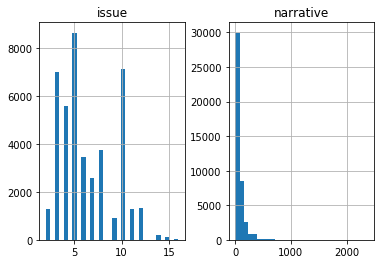

In [15]:
import matplotlib.pyplot as plt

narrative_word_count = []
issue_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_narrative']:
      narrative_word_count.append(len(i.split()))

for i in df['cleaned_issue']:
      issue_word_count.append(len(i.split()))

length_df = pd.DataFrame({'narrative':narrative_word_count, 'issue':issue_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
cnt=0
for i in df['cleaned_issue']:
    if(len(i.split())<=16):
        cnt=cnt+1
print(cnt/len(df['cleaned_issue']))# set the max number of summary to 16

1.0


In [17]:
cnt=0
for i in df['cleaned_narrative']:
    if(len(i.split())<=70):
        cnt=cnt+1
print(cnt/len(df['cleaned_narrative']))# set the max number of text to 70

0.6441916389197189


Let us select the reviews and summaries whose length falls below or equal to max_text_len and max_summary_len

In [18]:
max_narrative_len=70
max_issue_len=16

In [19]:
cleaned_narrative =np.array(df['cleaned_narrative'])
cleaned_issue=np.array(df['cleaned_issue'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_narrative)):
    if(len(cleaned_issue[i].split())<=max_issue_len and len(cleaned_narrative[i].split())<=max_narrative_len):
        short_text.append(cleaned_narrative[i])
        short_summary.append(cleaned_issue[i])
        
data=pd.DataFrame({'narrative':short_text,'issue':short_summary})

Add start and end

In [20]:
data['issue'] = data['issue'].apply(lambda x : 'sostok '+ x + ' eostok')

## 4. Split our dataset into a training and validation set. I will use 90% of the dataset as the training data and evaluate the performance on the remaining 10% 

In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['narrative']),np.array(data['issue']),test_size=0.1,random_state=0,shuffle=True)

## 5. Preparing the Tokenizer

Text Tokenizer

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for narrative on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Rarewords and its Coverage
Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [23]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 60.29060509554141
Total Coverage of rare words: 1.539298128389761


In [24]:
#prepare a tokenizer for narrative on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_narrative_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_narrative_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [25]:
x_voc

5986

Issue tokenizer

In [26]:
#prepare a tokenizer for issues on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Rarewords and its Coverage

In [27]:
thresh=100

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.49999999999999
Total Coverage of rare words: 3.1970195806619306


In [28]:
#prepare a tokenizer for issues on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_issue_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_issue_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [29]:
y_voc

154

In [30]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(25074, 25074)

Here, I am deleting the rows that contain only START and END tokens

In [31]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [32]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## 6. Model building

Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. 

Here, we are building a 3 stacked LSTM for the encoder:

In [33]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_narrative_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 100)      598600      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 70, 300), (N 481200      embedding[0][0]                  
_____________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

stop training once the validation loss increases:

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [36]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 24902 samples, validate on 2764 samples
Epoch 1/50
24902/24902 [==============================] - 78s 3ms/sample - loss: 1.3236 - val_loss: 0.6132
Epoch 2/50
24902/24902 [==============================] - 74s 3ms/sample - loss: 0.4185 - val_loss: 0.3081
Epoch 3/50
24902/24902 [==============================] - 74s 3ms/sample - loss: 0.2555 - val_loss: 0.2276
Epoch 4/50
24902/24902 [==============================] - 75s 3ms/sample - loss: 0.2050 - val_loss: 0.2012
Epoch 5/50
24902/24902 [==============================] - 75s 3ms/sample - loss: 0.1854 - val_loss: 0.1873
Epoch 6/50
24902/24902 [==============================] - 75s 3ms/sample - loss: 0.1724 - val_loss: 0.1741
Epoch 7/50
24902/24902 [==============================] - 75s 3ms/sample - loss: 0.1627 - val_loss: 0.1666
Epoch 8/50
24902/24902 [==============================] - 77s 3ms/sample - loss: 0.1562 - val_loss: 0.1641
E

## Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

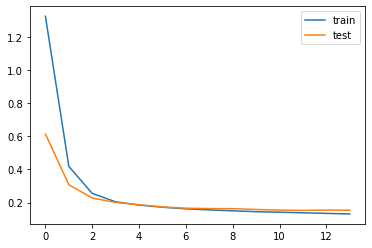

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 12 for 2 successive epochs. Hence, training is stopped at epoch 14.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [38]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## 7. Inference
Set up the inference for the encoder and decoder:

In [40]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_narrative_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered here):

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_issue_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [42]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [43]:
for i in range(0,100):
    print("Complaint:",seq2text(x_tr[i]))
    print("Original issue:",seq2summary(y_tr[i]))
    print("Predicted issue:",decode_sequence(x_tr[i].reshape(1,max_narrative_len)))
    print("\n")

Complaint: trans union dropped credit score pts paid entire remaining balance loan instead credit score going paying loan dropped pts account closed taking pain efforts stay debt paying debts im getting punished owning enough money enough debtors wrong 
Original issue: account status incorrect 
Predicted issue:  account status incorrect


Complaint: car loan report years illegal 
Original issue: old information reappears or never goes away 
Predicted issue:  did not receive enough information to verify debt


Complaint: sold paid debt national credit system information continue update accurate 
Original issue: debt was paid 
Predicted issue:  debt was paid


Complaint: credit report displayed charged closes month later begin age date fraudulently submitting began making payments dating back untrue fraud made payments account company caused able acquire loans support family severe injustice rights sent letters credit bureaus asking verify information delete account incorrect information